# Homework 9 - Descriptive Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the speech from Martin Luther King in the text.text file.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 4th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Phang Teng Fone
# Student ID: 1003296

In [2]:
from google.colab import drive
drive.mount('/content/drive')

rootPath = "/content/drive/MyDrive/SUTD_GSUITE/Year 3/Term 7/DeepLearning/Hw9"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/SUTD_GSUITE/Year\ 3/Term\ 7/DeepLearning/Hw9

/content/drive/MyDrive/SUTD_GSUITE/Year 3/Term 7/DeepLearning/Hw9


### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [4]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()

### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

In [5]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [6]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [7]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [8]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - word2index, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [9]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [10]:
print(vocab)

{'what', 'from', 'their', 'sacred', 'selfhood', 'dripping', 'society', 'reality', 'pursuit', 'louisiana', 'mountain', 'years', 'take', 'independence', 'sweet', 'where', 'spot', 'night', 'suffering', 'heir', 'dramatize', 'would', 'rock', 'stripped', 'day', 'robbed', 'created', 'content', 'hold', 'sense', 'demonstration', 'become', 'all', 'justice', 'declaration', 'despair', 'exile', 'dark', 'racial', 'color', 'battered', 'give', 'into', 'decree', 'prosperity', 'travel', 'last', 'and', 'democracy', 'country', 'persecutions', 'children', 'those', 'daybreak', 'your', 'refuse', 'shake', 'nineteen', 'stream', 'am', 'crooked', 'men', 'cannot', 'whose', 'some', 'hilltops', 'plains', 'interposition', 'island', 'hill', 'believe', 'low', 'not', 'urgency', 'foundations', 'died', 'vast', 'guaranteed', 'highways', 'pennsylvania', 'table', 'hands', 'be', 'truths', 'words', 'greatest', 'its', 'sons', 'sadly', 'citizens', 'protestants', 'discrimination', 'brutality', 'needed', 'as', 'york', 'pride', 't

In [11]:
print(word2index)

{'what': 0, 'from': 1, 'their': 2, 'sacred': 3, 'selfhood': 4, 'dripping': 5, 'society': 6, 'reality': 7, 'pursuit': 8, 'louisiana': 9, 'mountain': 10, 'years': 11, 'take': 12, 'independence': 13, 'sweet': 14, 'where': 15, 'spot': 16, 'night': 17, 'suffering': 18, 'heir': 19, 'dramatize': 20, 'would': 21, 'rock': 22, 'stripped': 23, 'day': 24, 'robbed': 25, 'created': 26, 'content': 27, 'hold': 28, 'sense': 29, 'demonstration': 30, 'become': 31, 'all': 32, 'justice': 33, 'declaration': 34, 'despair': 35, 'exile': 36, 'dark': 37, 'racial': 38, 'color': 39, 'battered': 40, 'give': 41, 'into': 42, 'decree': 43, 'prosperity': 44, 'travel': 45, 'last': 46, 'and': 47, 'democracy': 48, 'country': 49, 'persecutions': 50, 'children': 51, 'those': 52, 'daybreak': 53, 'your': 54, 'refuse': 55, 'shake': 56, 'nineteen': 57, 'stream': 58, 'am': 59, 'crooked': 60, 'men': 61, 'cannot': 62, 'whose': 63, 'some': 64, 'hilltops': 65, 'plains': 66, 'interposition': 67, 'island': 68, 'hill': 69, 'believe': 

In [12]:
print(index2word)

{0: 'what', 1: 'from', 2: 'their', 3: 'sacred', 4: 'selfhood', 5: 'dripping', 6: 'society', 7: 'reality', 8: 'pursuit', 9: 'louisiana', 10: 'mountain', 11: 'years', 12: 'take', 13: 'independence', 14: 'sweet', 15: 'where', 16: 'spot', 17: 'night', 18: 'suffering', 19: 'heir', 20: 'dramatize', 21: 'would', 22: 'rock', 23: 'stripped', 24: 'day', 25: 'robbed', 26: 'created', 27: 'content', 28: 'hold', 29: 'sense', 30: 'demonstration', 31: 'become', 32: 'all', 33: 'justice', 34: 'declaration', 35: 'despair', 36: 'exile', 37: 'dark', 38: 'racial', 39: 'color', 40: 'battered', 41: 'give', 42: 'into', 43: 'decree', 44: 'prosperity', 45: 'travel', 46: 'last', 47: 'and', 48: 'democracy', 49: 'country', 50: 'persecutions', 51: 'children', 52: 'those', 53: 'daybreak', 54: 'your', 55: 'refuse', 56: 'shake', 57: 'nineteen', 58: 'stream', 59: 'am', 60: 'crooked', 61: 'men', 62: 'cannot', 63: 'whose', 64: 'some', 65: 'hilltops', 66: 'plains', 67: 'interposition', 68: 'island', 69: 'hill', 70: 'believ

In [13]:
print(data)

[('happy', ['i', 'am', 'to', 'join']), ('to', ['am', 'happy', 'join', 'with']), ('join', ['happy', 'to', 'with', 'you']), ('with', ['to', 'join', 'you', 'today']), ('you', ['join', 'with', 'today', 'in']), ('today', ['with', 'you', 'in', 'what']), ('in', ['you', 'today', 'what', 'will']), ('what', ['today', 'in', 'will', 'go']), ('will', ['in', 'what', 'go', 'down']), ('go', ['what', 'will', 'down', 'in']), ('down', ['will', 'go', 'in', 'history']), ('in', ['go', 'down', 'history', 'as']), ('history', ['down', 'in', 'as', 'the']), ('as', ['in', 'history', 'the', 'greatest']), ('the', ['history', 'as', 'greatest', 'demonstration']), ('greatest', ['as', 'the', 'demonstration', 'for']), ('demonstration', ['the', 'greatest', 'for', 'freedom']), ('for', ['greatest', 'demonstration', 'freedom', 'in']), ('freedom', ['demonstration', 'for', 'in', 'the']), ('in', ['for', 'freedom', 'the', 'history']), ('the', ['freedom', 'in', 'history', 'of']), ('history', ['in', 'the', 'of', 'our']), ('of', [

In [14]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.FloatTensor):
    """
    This fucntion converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    tensor =  dtype([word2index[word] for word in words])
    tensor = tensor.cuda()
    
    return Variable(tensor)

### Step 2. Create a SkipGram model and train

Task #1: Write your own model for the SkipGram model below.

In [15]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(1 * embedding_dim, 128) # One target word

        self.linear2 = nn.Linear(128, context_size * vocab_size * 2) # Front and back, 2 context word * 2

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))

        out = self.linear2(out) # torch.Size([1, 1868])

        log_probs = F.log_softmax(out, dim=1).view(2*self.context_size, -1)
        return log_probs

In [16]:
# Create model and pass to CUDA
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.train()

SkipGram(
  (embeddings): Embedding(467, 20)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1868, bias=True)
)

In [17]:
# Define training parameters
learning_rate = 0.001
epochs = 50
torch.manual_seed(28)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [18]:
def get_prediction(context_idxs, model, target, index2word):
    """
    This is a helper function to get prediction from our model.
    """
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor([context_idxs], word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    outputPredWords = list()
    for i in range(prediction.shape[0]):
      currentPred = torch.reshape(prediction[i], (1, 467))
      _, index = torch.max(currentPred, 1)
      outputPredWords.append(index2word[index.item()])
    return outputPredWords

def check_accuracy(model, data, word2index, index2word):
    """
    This is a helper function to get accuracy from our model.
    """
    # Compute accuracy
    correct = 0
    accuracy = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        for item in target:
            if item in prediction:
                correct += 1
                prediction.pop(prediction.index(item))
            
    return correct/(len(data)*len(target))

Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [19]:
def train(data, word2index, model, epochs, loss_func, optimizer):
    losses = []
    accuracies = []

    # for epoch in range(10):
    for epoch in range(epochs):
        total_loss = 0
        for context, target in data: # context = happy, target = [i,am,to,join]

            # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
            # into integer indices and wrap them in tensors)
            context_idxs = words_to_tensor([context], word2index,dtype = torch.LongTensor)

            # Step 2. Recall that torch *accumulates* gradients. Before passing in a
            # new instance, you need to zero out the gradients from the old
            # instance
            model.zero_grad()

            # Step 3. Run the forward pass, getting log probabilities over next
            # words
            log_probs = model(context_idxs)

            # Step 4. Compute your loss function. (Again, Torch wants the target
            # word wrapped in a tensor)
            target_idxs = words_to_tensor(target, word2index,dtype = torch.LongTensor)
            loss = loss_func(log_probs, target_idxs)

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()

        # Display
        if epoch % 10 == 0:
            accuracy = check_accuracy(model, data, word2index, index2word)
            print("Accuracy after epoch {} is {}".format(epoch, accuracy))
            accuracies.append(accuracy)
            losses.append(total_loss)

    return losses, accuracies, model

losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer)

Accuracy after epoch 0 is 0.024377224199288255
Accuracy after epoch 10 is 0.11494661921708185
Accuracy after epoch 20 is 0.12099644128113879
Accuracy after epoch 30 is 0.15462633451957294
Accuracy after epoch 40 is 0.1895017793594306


### 3. Visualization

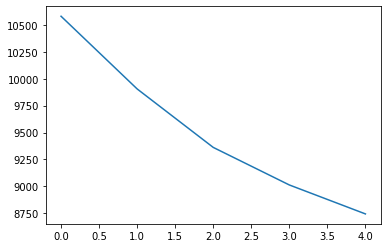

In [20]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

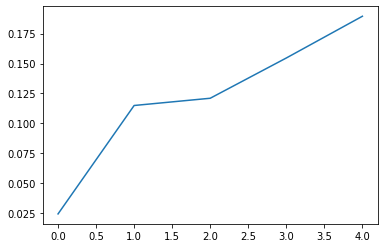

In [21]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

### Questions and expected answers for the report

A. Copy and paste your SkipGram class code (Task #1 in the notebook)

B. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration). Please also copy and paste the function call with the parameters you used for the train() function.

C. Why is the SkipGram model much more difficult to train than the CBoW. Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

D. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so. Please submit some code that will demonstrate the performance/problems of the word embedding you have trained!

### A.

In [22]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(1 * embedding_dim, 128) # One target word

        self.linear2 = nn.Linear(128, context_size * vocab_size * 2) # Front and back, 2 context word * 2

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))

        out = self.linear2(out) # torch.Size([1, 1868])

        log_probs = F.log_softmax(out, dim=1).view(2*self.context_size, -1)
        return log_probs

### B.

In [23]:
def get_prediction(context_idxs, model, target, index2word):
    """
    This is a helper function to get prediction from our model.
    """
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor([context_idxs], word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    outputPredWords = list()
    for i in range(prediction.shape[0]):
      currentPred = torch.reshape(prediction[i], (1, 467))
      _, index = torch.max(currentPred, 1)
      outputPredWords.append(index2word[index.item()])
    return outputPredWords

def check_accuracy(model, data, word2index, index2word):
    """
    This is a helper function to get accuracy from our model.
    """
    # Compute accuracy
    correct = 0
    accuracy = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        for item in target:
            if item in prediction:
                correct += 1
                prediction.pop(prediction.index(item))
            
    return correct/(len(data)*len(target))

### C.

It is more difficult to train as we are trying to predict all contextual words with a targetted word compared to only predicting one targetted word with all contextual word (CBOW). It is not problematic if it does not reach 100%. Skipgram main objective is to train a good embedding W, the order of output words does not matter too, thus having a high accuracy does not impact much on the overall embedding

### D.

In [24]:
word1 = words_to_tensor(["america"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["nation"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["demonstration"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)


print("America and Nation have a somewhat close semantic meaning (strong positive value)")
print(torch.dot(w1, w2).item())
print("America and demonstration do not have a close semantic meaning (strong neg value)")
print(torch.dot(w1, w3).item())

tensor([-1.4991, -0.2592, -0.2043, -0.1762,  1.2631, -0.4144, -0.0608, -4.1929,
         1.7622, -0.7512,  1.9801, -1.0208, -0.4909,  0.7981,  0.5592, -0.5987,
         0.0446,  1.9117, -0.0500,  0.0254], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([-0.8956, -0.7040,  2.0311, -0.7223,  1.9538, -0.6704, -0.1494,  0.3200,
         0.7476, -0.4033, -0.8843,  0.4629,  0.9916, -0.1919, -0.1969,  0.1814,
         0.2082,  0.6525,  0.6598,  0.7197], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([-6.3630e-01,  2.2689e-01, -1.6085e-01,  5.5092e-01, -4.1518e-01,
        -2.6361e-01,  2.3517e+00, -2.6724e-01, -1.3479e-01,  2.6846e-01,
         1.8943e-01,  1.1656e+00,  1.0835e+00,  6.1710e-04, -4.3264e-01,
        -1.4330e-01,  9.4555e-01, -2.2146e-01, -1.7651e+00,  8.2993e-01],
       device='cuda:0', grad_fn=<ViewBackward>)
America and Nation have a somewhat close semantic meaning (strong positive value)
2.430832862854004
America and demonstration do not have a close semanti

In [26]:
word1 = words_to_tensor(["mountainside"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["slopes"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["valley"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)


print("Mountainside and slopes have a somewhat close semantic meaning (strong positive value)")
print(torch.dot(w1, w2).item())
print("Mountainside and valley should also have a somewhat close semantic meaning (strong positive value)")
print(torch.dot(w1, w3).item())

tensor([-1.8062, -1.4620,  0.3667, -0.8975,  0.6860, -0.2239,  0.8429, -1.3587,
         1.8531, -0.2217,  1.5407,  0.2024, -0.7140,  0.0891,  1.4018, -0.8829,
         2.5345,  0.0723, -0.0878,  0.7748], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([ 1.4582,  0.9746,  0.9009,  0.3001,  0.3280,  0.8345,  0.8753, -0.7369,
        -1.0315, -0.8690, -1.4339,  0.3043,  0.9067, -1.2675,  1.4453,  0.6492,
        -0.2720, -0.0086, -1.1627, -1.3617], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([-1.1825,  0.1017, -1.0729, -1.3155, -2.1004,  0.3562,  0.1041,  0.4351,
        -0.1937,  0.4117, -0.7062,  0.9733,  0.1934, -0.7167,  0.7011, -1.5611,
         1.0184,  0.6804, -0.8357, -0.0144], device='cuda:0',
       grad_fn=<ViewBackward>)
Mountainside and slopes have a somewhat close semantic meaning (strong positive value)
-7.037379264831543
Mountainside and valley should also have a somewhat close semantic meaning (strong positive value)
4.260671138763428


One method is to use human expert to judge whether the eword embedding is good or not. We can see the semmantic meaning of the word by dotting two words together. In one example, 'america' and 'nation' is tied closely to one another as semantically America is a nation, thus there is a positive high semantic score while for 'america' and 'demonstration' it carries a negative semantic score as it does not have much relation between the two words. However, one problem this method face is that it does not cover all possible semantic values of a word, probably oweing to the insufficient contexture words and the number of times it appears in the corpus. The example of "mountains" "slopes" and "valleys" all contains similar meaning semantically but it shows mountainside and slopes a strong negative score